In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import time
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [2]:
image_size = 112
batch_size = 16

train_dir = r"/kaggle/input/leaf-dataset/augmented/train"
val_dir = r"/kaggle/input/leaf-dataset/augmented/val"
test_dir = r"/kaggle/input/leaf-dataset/augmented/test"


datagen_train = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,
                                  horizontal_flip=True,  vertical_flip=False)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=train_dir, target_size=(image_size, image_size),
                                                    batch_size=batch_size, shuffle=True)
val_generator = datagen_test.flow_from_directory(directory=val_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)
test_generator = datagen_test.flow_from_directory(directory=test_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)

# Define the number of classes in your dataset
num_classes = train_generator.num_classes

Found 5000 images belonging to 30 classes.
Found 1500 images belonging to 30 classes.
Found 2500 images belonging to 30 classes.


In [3]:
def modelfunction(base):
    
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model 

def get_callbacks(weight):
    
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    callbacks = [earlystop, checkpoint, learning_rate_reduction]
    return callbacks

def evaluate(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()
    # Generate AUC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Measure inference time
    num_samples = len(generator_test)
    total_time = time.time() - start_time
    inference_time_per_sample = total_time / num_samples
    print("Inference Time: {:.4f} seconds per sample".format(inference_time_per_sample))
    
def model_training(base, weight, epochs):

    model = modelfunction(base)
    print("\n\n\n-------------------- Model Initialized --------------------")
    
    callbacks = get_callbacks(weight)
    metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
               tfa.metrics.CohenKappa(num_classes = num_classes), tfa.metrics.F1Score(num_classes = num_classes)]
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics= metrics)
    
    history = model.fit(train_generator, steps_per_epoch=366 // batch_size, epochs=epochs, callbacks=callbacks, 
                        validation_data= val_generator)
    
    print("\n\n\n-------------------- Evaluation --------------------")
    evaluate(model, val_generator)
    
    return model 

58889256/58889256 [==============================] - 0s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 21.0432 - accuracy: 0.0540 - auc: 0.4798 - precision: 0.0000e+00 - recall: 0.0000e+00 - cohen_kappa: 0.0237 - f1_score: 0.0336
Epoch 1: val_loss improved from inf to 20.69122, saving model to Vgg16.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 40s 1s/step - loss: 21.0432 - accuracy: 0.0540 - auc: 0.4798 - precision: 0.0000e+00 - recall: 0.0000e+00 - cohen_kappa: 0.0237 - f1_score: 0.0336 - val_loss: 20.6912 - val_accuracy: 0.0593 - val_auc: 0.5430 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_cohen_kappa: 0.0264 - val_f1_score: 0.0251 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 20.7281 - accuracy: 0.0369 - auc: 0.5401 - precision: 0.0000e+00 - recall: 0.0000e+00 - cohen_kappa: 0.0047 - f1_score: 0.0262
Epoch 2: val_loss improved from 20.69122 to 20.41829, saving model to Vgg16.h5
22/22 [==============================] - 18s 832ms/step - loss: 20.7281 - accuracy: 0.0369 - auc: 0.5401 - precision: 0.0000e+00 - recall: 0.0000e+00 - cohen_kappa: 0.0047 - f1_score: 0.0262 - val_loss: 20.4183 - val_accuracy: 0.0873 - val_auc: 0.6855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_cohen_kappa: 0.0539 - val_f1_score: 0.0577 - lr

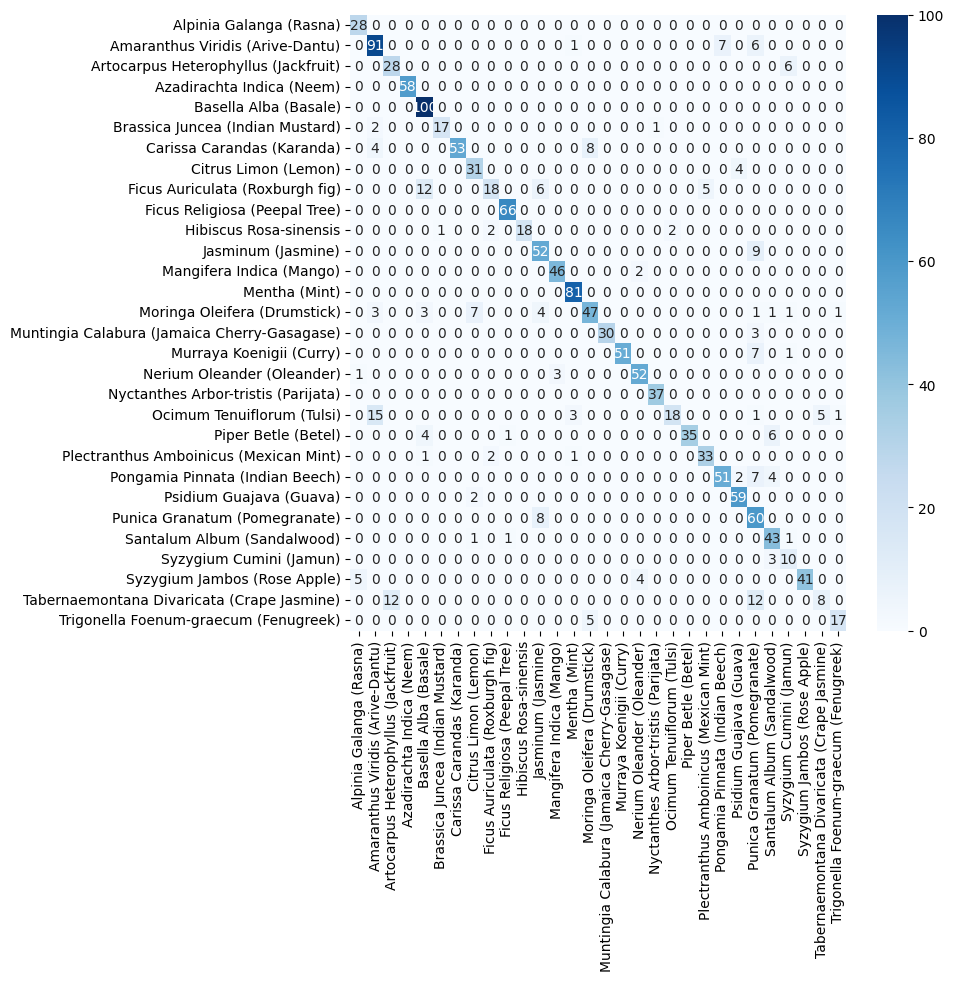

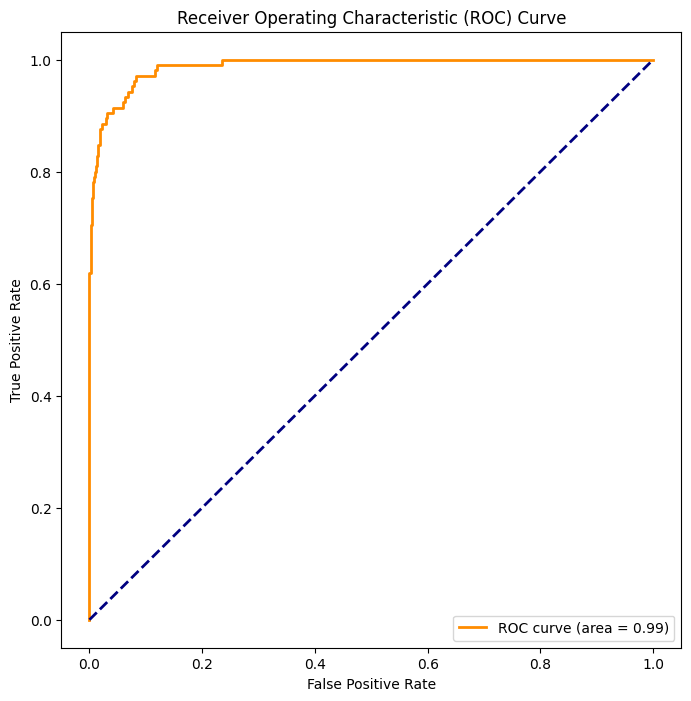

NameError: name 'start_time' is not defined

In [4]:
Vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Vgg16 = model_training(Vgg16,'Vgg16.h5', 30)

234698864/234698864 [==============================] - 1s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 38.1220 - accuracy: 0.0597 - auc_1: 0.5348 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: 0.0285 - f1_score: 0.0593
Epoch 1: val_loss improved from inf to 38.11471, saving model to ResNet152.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 132s 1s/step - loss: 38.1220 - accuracy: 0.0597 - auc_1: 0.5348 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: 0.0285 - f1_score: 0.0593 - val_loss: 38.1147 - val_accuracy: 0.0160 - val_auc_1: 0.4871 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_cohen_kappa: -0.0033 - val_f1_score: 0.0030 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 37.6439 - accuracy: 0.0426 - auc_1: 0.6009 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: 0.0093 - f1_score: 0.0460
Epoch 2: val_loss did not improve from 38.11471
22/22 [==============================] - 17s 779ms/step - loss: 37.6439 - accuracy: 0.0426 - auc_1: 0.6009 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: 0.0093 - f1_score: 0.0460 - val_loss: 38.5404 - val_accuracy: 0.0227 - val_auc_1: 0.5026 - val_precision_1: 0.0056 - val_recall_1: 6.6667e-04 - val_cohen_kappa: 0.0032 - val_f1_score: 0.0119 - lr: 1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


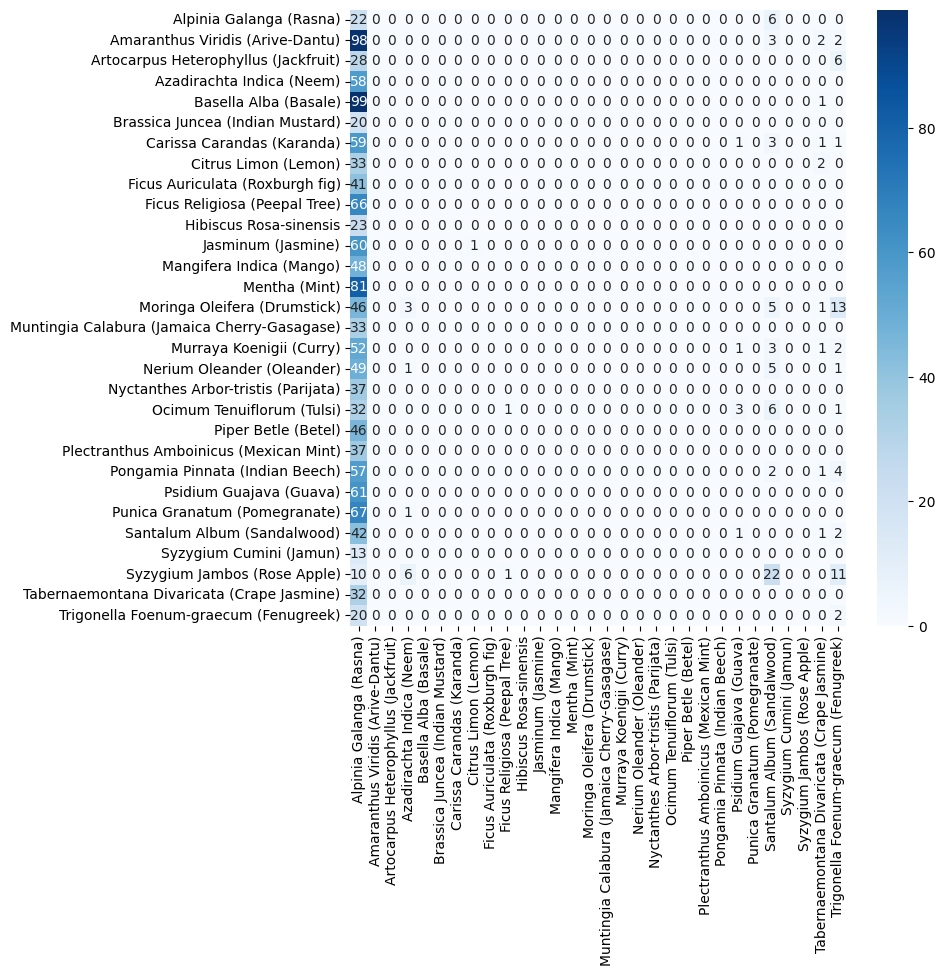

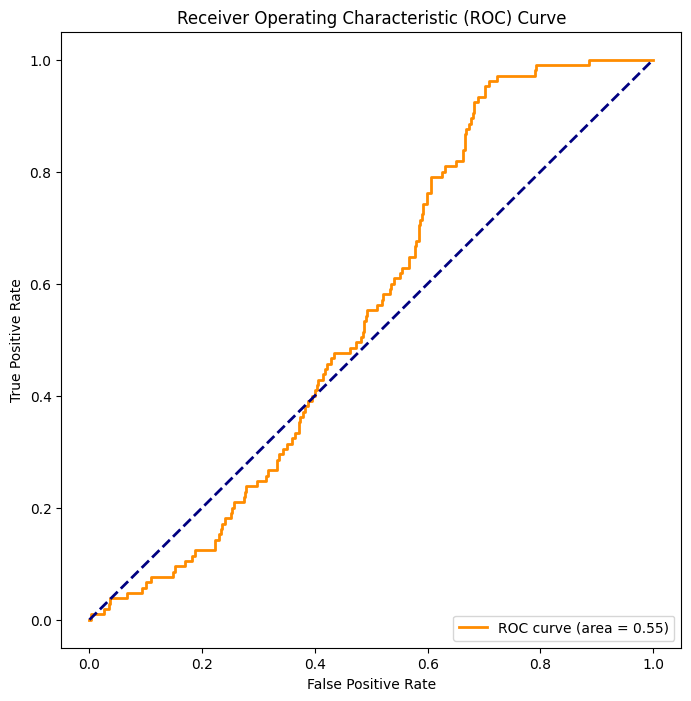

NameError: name 'start_time' is not defined

In [5]:
ResNet152 = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

ResNet152= model_training(ResNet152,'ResNet152.h5', 30)

219055592/219055592 [==============================] - 1s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 33.1799 - accuracy: 0.0341 - auc_2: 0.5269 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - cohen_kappa: -1.5879e-04 - f1_score: 0.0211
Epoch 1: val_loss improved from inf to 33.02575, saving model to InceptionResNetV2.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 116s 1s/step - loss: 33.1799 - accuracy: 0.0341 - auc_2: 0.5269 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - cohen_kappa: -1.5879e-04 - f1_score: 0.0211 - val_loss: 33.0257 - val_accuracy: 0.0360 - val_auc_2: 0.5317 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_cohen_kappa: 0.0085 - val_f1_score: 0.0299 - lr: 1.0000e-05
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 32.8868 - accuracy: 0.0653 - auc_2: 0.5731 - precision_2: 0.5000 - recall_2: 0.0028 - cohen_kappa: 0.0299 - f1_score: 0.0499        
Epoch 2: val_loss improved from 33.02575 to 32.75322, saving model to InceptionResNetV2.h5
22/22 [==============================] - 19s 908ms/step - loss: 32.8868 - accuracy: 0.0653 - auc_2: 0.5731 - precision_2: 0.5000 - recall_2: 0.0028 - cohen_kappa: 0.0299 - f1_score: 0.0499 - val_loss: 32.7532 - val_accuracy: 0.0360 - val_auc_2: 0.5392 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_cohen_k

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


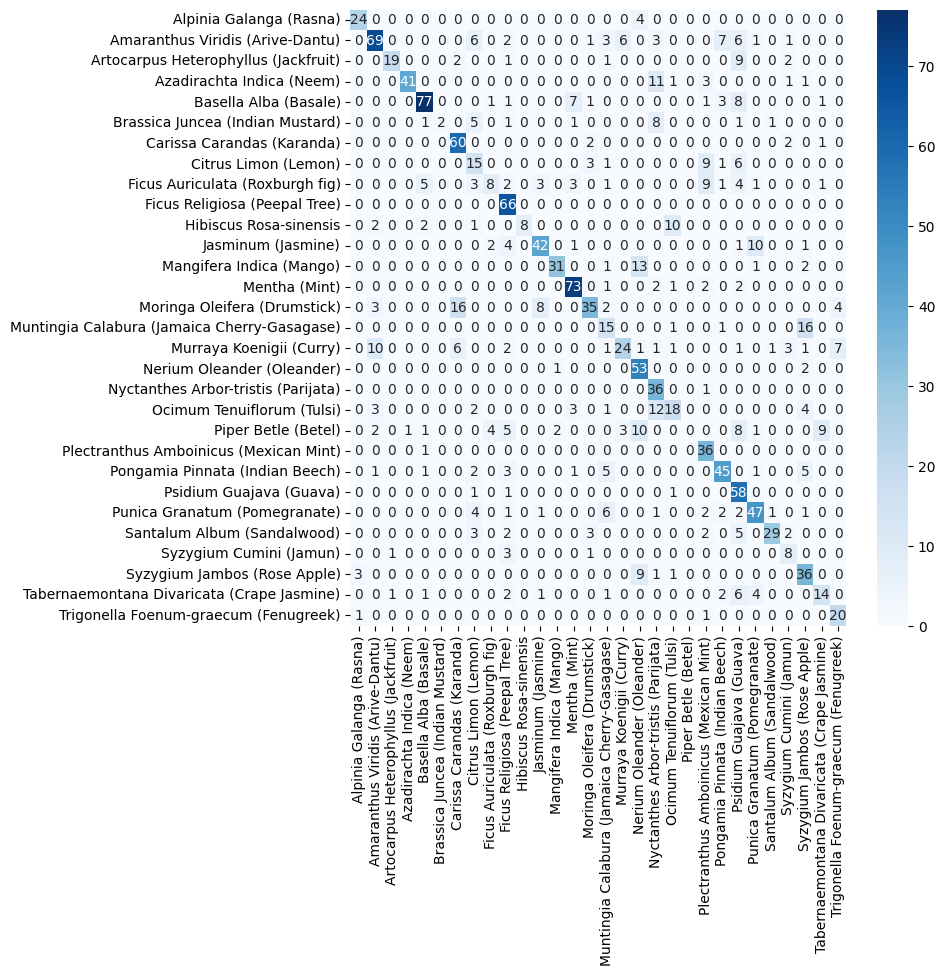

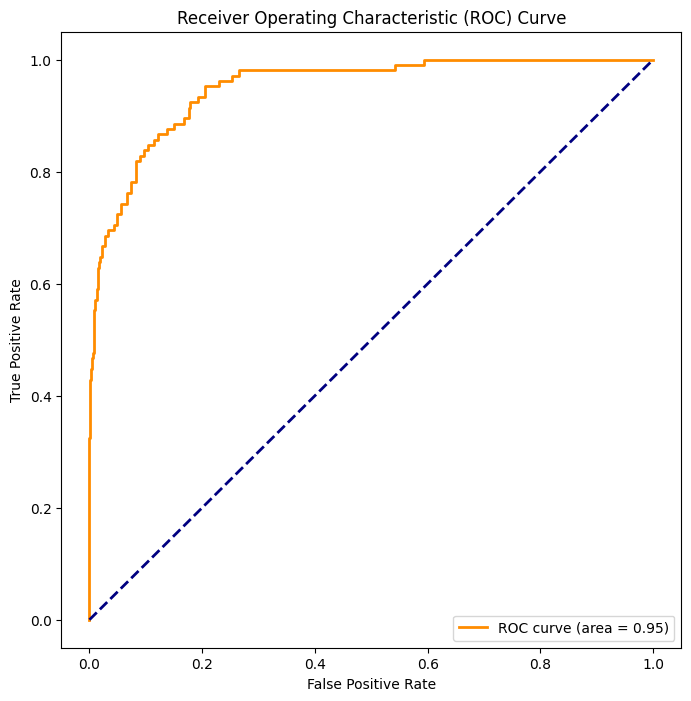

NameError: name 'start_time' is not defined

In [6]:
InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

InceptionResNetV2= model_training(InceptionResNetV2,'InceptionResNetV2.h5', 50)

350926856/350926856 [==============================] - 2s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 28.4065 - accuracy: 0.0227 - auc_3: 0.5152 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: -0.0104 - f1_score: 0.0191
Epoch 1: val_loss improved from inf to 27.83192, saving model to ConvNeXtBase.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 106s 1s/step - loss: 28.4065 - accuracy: 0.0227 - auc_3: 0.5152 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: -0.0104 - f1_score: 0.0191 - val_loss: 27.8319 - val_accuracy: 0.0573 - val_auc_3: 0.5967 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_cohen_kappa: 0.0228 - val_f1_score: 0.0332 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 28.0298 - accuracy: 0.0398 - auc_3: 0.5752 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: 0.0035 - f1_score: 0.0369
Epoch 2: val_loss improved from 27.83192 to 27.45943, saving model to ConvNeXtBase.h5
22/22 [==============================] - 22s 1s/step - loss: 28.0298 - accuracy: 0.0398 - auc_3: 0.5752 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: 0.0035 - f1_score: 0.0369 - val_loss: 27.4594 - val_accuracy: 0.1093 - val_auc_3: 0.6769 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_cohen_kappa

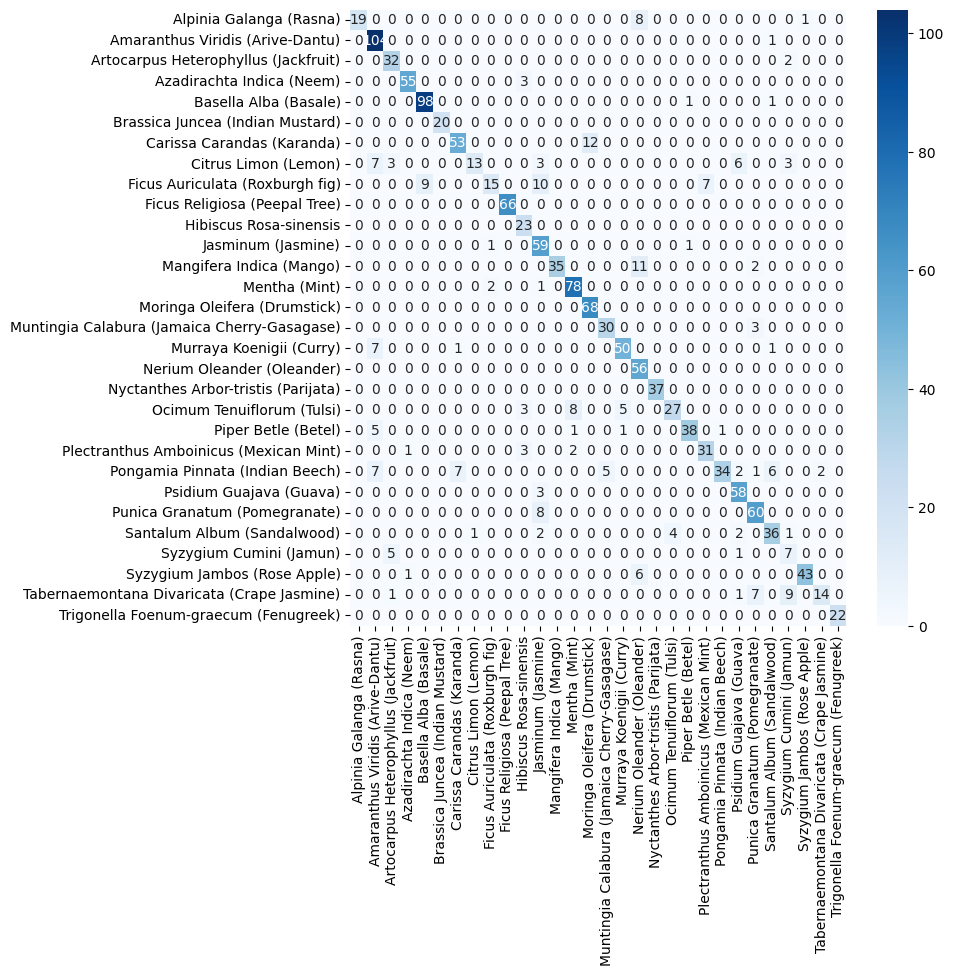

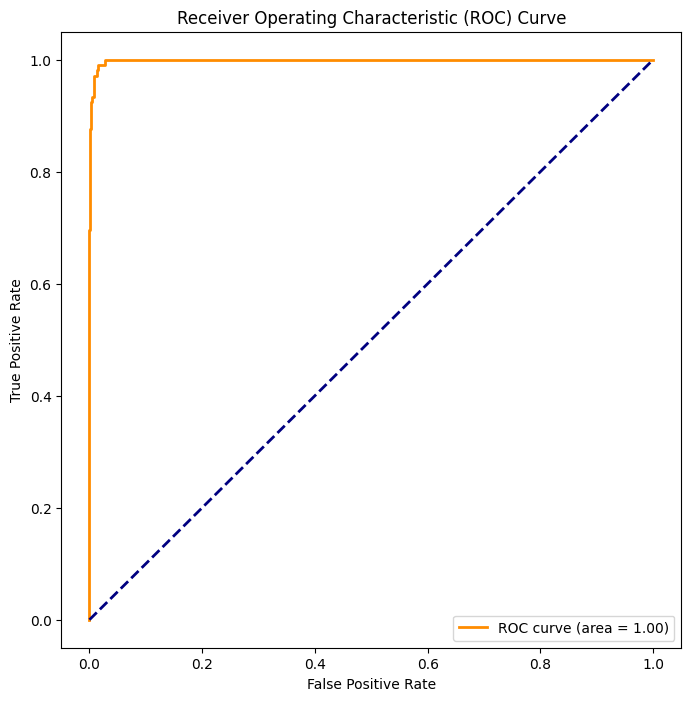

NameError: name 'start_time' is not defined

In [7]:
ConvNeXtBase = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

ConvNeXtBase= model_training(ConvNeXtBase,'ConvNeXtBase.h5', 30)

785596384/785596384 [==============================] - 3s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 33.7394 - accuracy: 0.0142 - auc_4: 0.5132 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - cohen_kappa: -0.0182 - f1_score: 0.0140
Epoch 1: val_loss improved from inf to 32.95747, saving model to ConvNeXtLarge.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 116s 2s/step - loss: 33.7394 - accuracy: 0.0142 - auc_4: 0.5132 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - cohen_kappa: -0.0182 - f1_score: 0.0140 - val_loss: 32.9575 - val_accuracy: 0.0827 - val_auc_4: 0.6262 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_cohen_kappa: 0.0516 - val_f1_score: 0.0581 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 33.0500 - accuracy: 0.0739 - auc_4: 0.6136 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - cohen_kappa: 0.0386 - f1_score: 0.0627
Epoch 2: val_loss improved from 32.95747 to 32.50277, saving model to ConvNeXtLarge.h5
22/22 [==============================] - 39s 2s/step - loss: 33.0500 - accuracy: 0.0739 - auc_4: 0.6136 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - cohen_kappa: 0.0386 - f1_score: 0.0627 - val_loss: 32.5028 - val_accuracy: 0.1987 - val_auc_4: 0.7123 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_cohen_kapp

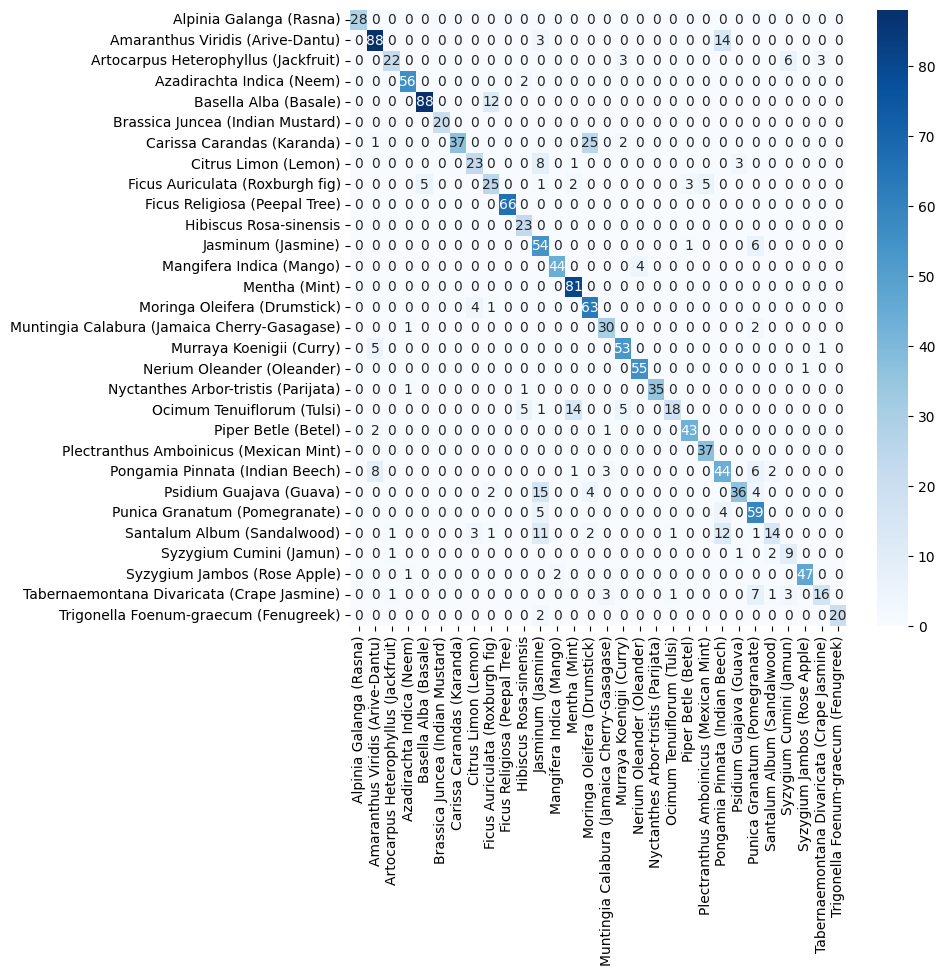

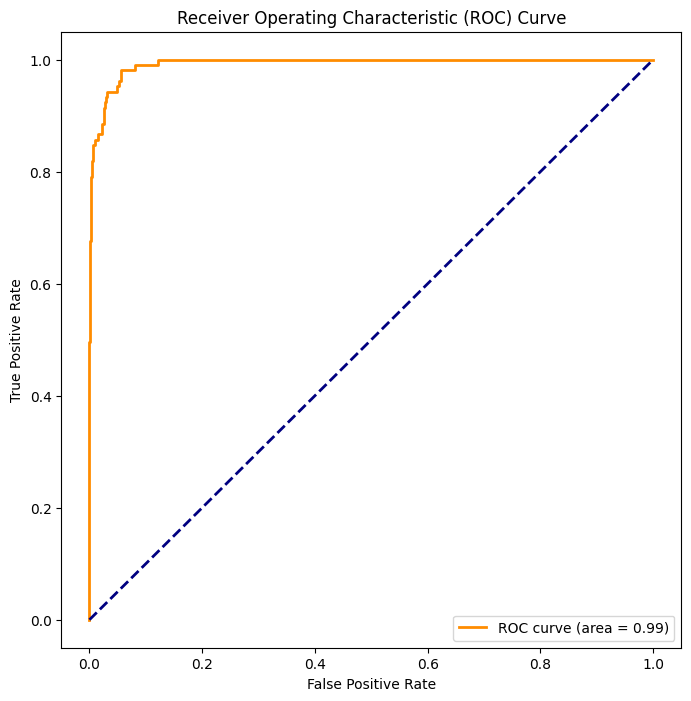

NameError: name 'start_time' is not defined

In [8]:
ConvNeXtLarge = tf.keras.applications.ConvNeXtLarge(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

ConvNeXtLarge= model_training(ConvNeXtLarge,'ConvNeXtLarge.h5', 30)